# ⭐**Conditional Workflow**

### 🧱 **Evolution of Workflows in LangGraph**

1. **Sequential Workflows**:

   * Tasks run one after another in a fixed order.
   * Example: `Task A` → `Task B` → `Task C`.

2. **Parallel Workflows**:

   * Tasks split and run *simultaneously* from a single point.
   * Example: After `Task 1`, both `Task 2` and `Task 3` run in parallel → their outputs feed into `Task 4`.

---

### 🔀 **Introduction to Conditional Workflows**

3. **Core Concept**:

   * Like parallel workflows in structure but with a key difference: **only one branch is executed**, based on a **condition**.
   * Works similar to **if-else logic** in programming.

4. **Programming Analogy**:

   * Comparable to `if-elif-else` statements.
   * Only the branch matching the condition is followed; others are skipped.

5. **Significance**:

   * Essential for **complex, decision-based** workflows.
   * Expected to be used **frequently** in advanced LangGraph applications—just like `if-else` is in regular coding.

## ⭕ **Quadratic Equation Workflow**

**Quadratic Equation Solver: Mathematical Formulas**

The code implements a solver for the standard quadratic equation:

$ax^2 + bx + c = 0$

---

**1. Show the Equation**

Displays the equation in standard form:

$ax^2 + bx + c = 0$



---

**2. Calculate the Discriminant**

Computes the discriminant $D$:


$D = b^2 \;-\; 4ac$



---

**3. Solve Based on Discriminant**

**Branching logic** (in `check_condition`):

- If $D > 0$, there are two distinct real roots.  
- If $D = 0$, there is exactly one (repeated) real root. (i.e both the roots are same)
- If $D < 0$, there are no real roots.

---

**Case A: Two Real Roots \((D > 0)\)**


$x = \frac{-b \pm \sqrt{D}}{2a}$



Which expands to  

$x_1 = \frac{-b + \sqrt{b^2 - 4ac}}{2a}$

$x_2 = \frac{-b - \sqrt{b^2 - 4ac}}{2a}$



---

**Case B: One Repeated Root \((D = 0)\)**

$x = \frac{-b}{2a}$ 


---

**Case C: No Real Roots \((D < 0)\)**

No solutions in the set of real numbers.

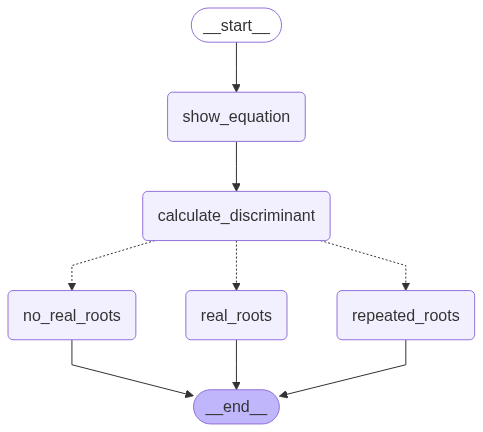

In [ ]:
# Imports
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from dotenv import load_dotenv
load_dotenv()

# Define the state structure used in the graph
class QuadState(TypedDict):
    a: int
    b: int
    c: int
    equation: str
    discriminant: float
    result: str

# Step 1: Show the quadratic equation in a readable format
def show_equation(state: QuadState):
    # Proper formatting of equation like: 1x² + 2x + 3
    equation = f'{state["a"]}x² + {state["b"]}x + {state["c"]}'
    return {"equation": equation}

# Step 2: Calculate the discriminant (b² - 4ac)
def calculate_discriminant(state: QuadState):
    discriminant = state["b"]**2 - 4 * state["a"] * state["c"]
    return {"discriminant": discriminant}

# Step 3a: If discriminant > 0 → Two distinct real roots
def real_roots(state: QuadState):
    # Corrected denominator from 2*b ➝ 2*a
    root_1 = (-state["b"] + state["discriminant"]**0.5) / (2 * state["a"])
    root_2 = (-state["b"] - state["discriminant"]**0.5) / (2 * state["a"])
    result = f"The roots are {root_1:.2f} and {root_2:.2f}"
    return {"result": result}

# Step 3b: If discriminant == 0 → One repeated root
def repeated_roots(state: QuadState):
    root = -state["b"] / (2 * state["a"])
    result = f"Only repeating root is {root:.2f}"
    return {"result": result}

# Step 3c: If discriminant < 0 → No real roots
def no_real_roots(state: QuadState):
    result = "No real roots"
    return {"result": result}

# Conditional branching based on discriminant value
def check_condition(state: QuadState) -> Literal["real_roots", "repeated_roots", "no_real_roots"]:
    if state["discriminant"] > 0:
        return "real_roots"
    elif state["discriminant"] == 0:
        return "repeated_roots"
    else:
        return "no_real_roots"

# Build the LangGraph
graph = StateGraph(QuadState)

# Add nodes to the graph
graph.add_node("show_equation", show_equation)
graph.add_node("calculate_discriminant", calculate_discriminant)
graph.add_node("real_roots", real_roots)
graph.add_node("repeated_roots", repeated_roots)
graph.add_node("no_real_roots", no_real_roots)

# Define the graph edges (flow)
graph.add_edge(START, "show_equation")
graph.add_edge("show_equation", "calculate_discriminant")

# Conditional path branching after discriminant evaluation
graph.add_conditional_edges("calculate_discriminant", check_condition)

# All result-producing nodes go to END
graph.add_edge("real_roots", END)
graph.add_edge("repeated_roots", END)
graph.add_edge("no_real_roots", END)

# Compile the workflow
workflow = graph.compile()
workflow

In [16]:
initial_state = {
    'a' : 4, 
    'b' : -5, 
    'c' : -4
}

workflow.invoke(initial_state)

{'a': 4,
 'b': -5,
 'c': -4,
 'equation': '4x² + -5x + -4',
 'discriminant': 89,
 'result': 'The roots are 1.80 and -0.55'}

## ⭕ **Loan Approval System**

**We'll build a LangGraph workflow that:**

- Gathers applicant data
- Calculates a credit score
- Decides based on multiple thresholds:
  - 🟢 Approve loan
  - 🟡 Refer to manual review
  - 🔴 Reject loan
- Each condition leads to a different downstream path with more logic.

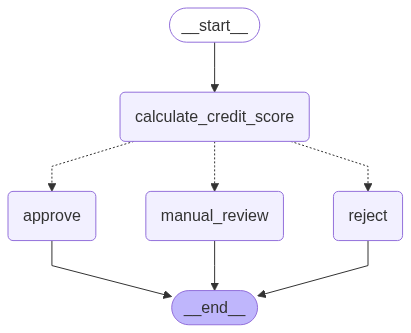

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal

class LoanState(TypedDict):
    name: str
    age: int
    income: float
    loan_amount: float
    credit_score: float
    decision: str
    remarks: str

# Step 1: Calculate Credit Score
def calculate_credit_score(state: LoanState):
    score = (state["income"] / state["loan_amount"]) * 100
    return {"credit_score": score}

# Step 2: Evaluate Credit Score
def evaluate_credit_score(state: LoanState) -> Literal["approve", "manual_review", "reject"]:
    score = state["credit_score"]
    if score >= 250:
        return "approve"
    elif 150 <= score < 250:
        return "manual_review"
    else:
        return "reject"

# Step 3a: Auto-Approval Logic
def approve_loan(state: LoanState):
    return {
        "decision": "Approved ✅",
        "remarks": f"Loan approved for {state['name']} with credit score {state['credit_score']:.2f}"
    }

# Step 3b: Manual Review Path
def manual_review(state: LoanState):
    remarks = f"Loan referred for manual review for {state['name']}."
    return {"decision": "Pending Manual Review 🕵️‍♂️", "remarks": remarks}

# Step 3c: Auto-Rejection Logic
def reject_loan(state: LoanState):
    return {
        "decision": "Rejected ❌",
        "remarks": f"Loan rejected for {state['name']} due to low credit score ({state['credit_score']:.2f})"
    }

# Create graph
graph = StateGraph(LoanState)

graph.add_node("calculate_credit_score", calculate_credit_score)
graph.add_node("approve", approve_loan)
graph.add_node("manual_review", manual_review)
graph.add_node("reject", reject_loan)

# Connect nodes
graph.add_edge(START, "calculate_credit_score")
graph.add_conditional_edges("calculate_credit_score", evaluate_credit_score)
graph.add_edge("approve", END)
graph.add_edge("manual_review", END)
graph.add_edge("reject", END)

# Compile the workflow
workflow = graph.compile()

workflow

In [3]:
initial_state = {
    "name": "Alice",
    "age": 30,
    "income": 6000,
    "loan_amount": 200,
}

result = workflow.invoke(initial_state)
print(result)

{'name': 'Alice', 'age': 30, 'income': 6000, 'loan_amount': 200, 'credit_score': 3000.0, 'decision': 'Approved ✅', 'remarks': 'Loan approved for Alice with credit score 3000.00'}


## ⭕ **Smart Customer Support Bot with Escalation Path**

**🔍 Goal:**
***Create a multi-path workflow that:***
- Handles customer complaints
- Uses basic NLP logic to route tickets
- Escalates to a human agent if:
  - *User is angry (based on sentiment)*
  - *Or it's a high-priority issue*
  - *Or the bot failed to resolve the issue*
- Resolves simple issues automatically

---

**💡 Core Concepts Used:**
- Conditional branching based on sentiment + issue category
- Auto-resolution vs escalation
- NLP-like keyword-based routing

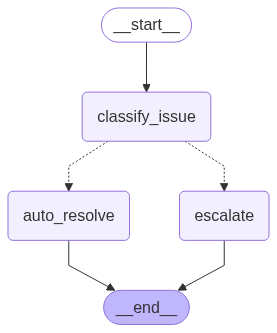

In [4]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal

class SupportState(TypedDict):
    user_name: str
    issue: str
    sentiment: str
    category: str
    decision: str
    resolution: str

# Step 1: Simple Sentiment + Category Classification (mocked)
def classify_issue(state: SupportState):
    issue = state["issue"].lower()
    sentiment = "angry" if "refund" in issue or "worst" in issue else "neutral"
    
    if "payment" in issue or "refund" in issue:
        category = "billing"
    elif "login" in issue:
        category = "authentication"
    elif "feature" in issue:
        category = "product"
    else:
        category = "general"
    
    return {"sentiment": sentiment, "category": category}

# Step 2: Condition-Based Decision Path
def route_ticket(state: SupportState) -> Literal["auto_resolve", "escalate"]:
    # Escalate if angry or critical category
    if state["sentiment"] == "angry" or state["category"] in ["billing", "authentication"]:
        return "escalate"
    return "auto_resolve"

# Step 3a: Auto-Resolution
def auto_resolve(state: SupportState):
    msg = f"Hi {state['user_name']}, we’ve resolved your issue regarding {state['category']} ✅"
    return {"decision": "Resolved Automatically", "resolution": msg}

# Step 3b: Escalate to Human
def escalate(state: SupportState):
    msg = f"Hi {state['user_name']}, your {state['category']} issue has been escalated to a human agent 🚨"
    return {"decision": "Escalated to Human", "resolution": msg}

# Build the graph
graph = StateGraph(SupportState)

graph.add_node("classify_issue", classify_issue)
graph.add_node("auto_resolve", auto_resolve)
graph.add_node("escalate", escalate)

graph.add_edge(START, "classify_issue")
graph.add_conditional_edges("classify_issue", route_ticket)
graph.add_edge("auto_resolve", END)
graph.add_edge("escalate", END)

workflow = graph.compile()
workflow

In [5]:
workflow.invoke({
    "user_name": "Rohit",
    "issue": "I want a refund! Worst service ever.",
})

{'user_name': 'Rohit',
 'issue': 'I want a refund! Worst service ever.',
 'sentiment': 'angry',
 'category': 'billing',
 'decision': 'Escalated to Human',
 'resolution': 'Hi Rohit, your billing issue has been escalated to a human agent 🚨'}

## ⭕ **LLM based Review Handling Workflow**

### 🔄 **LLM-Based Review Handling Workflow (LangGraph)**

* **🎯 Goal**:

  * Take a customer review → Analyze sentiment → Generate appropriate response.

---

### 🧠 Step 1: Sentiment Analysis

* Input: Customer review text.
* Uses **GPT-4o mini** to classify sentiment (**Positive** or **Negative**).
* Utilizes `SentimentSchema` to enforce structured output.

---

### 🔀 Step 2: Conditional Workflow (Based on Sentiment)

* Handled by `check_sentiment` function.
* Like an **if-else** branch:

  * **Positive → Positive Response**
  * **Negative → Diagnosis → Negative Response**

---

### ✅ Positive Sentiment Path

* Node: `positive_response`
* LLM generates:

  * Warm thank-you message.
  * Prompt to leave feedback on website.

---

### ❌ Negative Sentiment Path

* Node 1: `run_diagnosis`

  * LLM extracts structured data via `DiagnosisSchema`:

    1. **Issue Type** (e.g., UX, bug, support)
    2. **Tonality** (e.g., angry, polite, confused)
    3. **Urgency** (low, medium, high)
* Node 2: `negative_response`

  * LLM generates empathetic, helpful response using diagnosis data.

---

### ⚙️ LangGraph Structure

* **State (`ReviewState`)**:

  * `review`, `sentiment`, `diagnosis`, `response`
* **Nodes**:

  * `find_sentiment`, `positive_response`, `run_diagnosis`, `negative_response`
* **Edges**:

  * Regular: `start → find_sentiment → [response nodes] → end`
  * Conditional: `find_sentiment → (positive or negative branch)`

---

### ✅ Outcome:

* Smart, **context-aware**, and **tailored replies** based on review sentiment and details.


negative


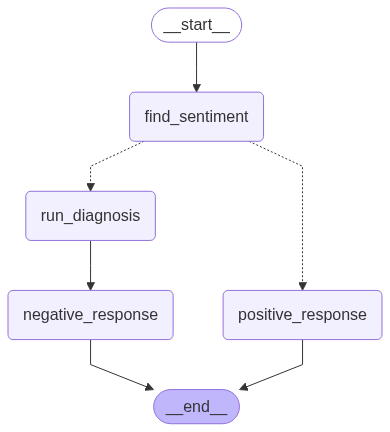

In [ ]:
# ===============================
# Imports
# ===============================
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

# ===============================
# Environment Setup
# ===============================
load_dotenv()

# ===============================
# LLM Model Initialization
# ===============================
model = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.7,
    max_tokens=100
)

# ===============================
# Output Schemas
# ===============================
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="Sentiment of the review")

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description="The category of issue mentioned in the review")
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description="The emotional tone expressed by the user")
    urgency: Literal["low", "medium", "high"] = Field(description="How urgent or critical the issue appears to be")

# ===============================
# Structured Output Wrappers
# ===============================
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

# ===============================
# Quick Test (Optional)
# ===============================
prompt = "What is the sentiment of the following review - The software is buggy"
print(structured_model.invoke(prompt).sentiment)

# ===============================
# Review State Definition
# ===============================
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

# ===============================
# Step: Find Sentiment
# ===============================
def find_sentiment(state: ReviewState):
    prompt = f"For the following review find out the sentiment:\n{state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {'sentiment': sentiment}

# ===============================
# Conditional Step: Check Sentiment
# ===============================
def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

# ===============================
# Step: Positive Response
# ===============================
def positive_response(state: ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review:
                \n\n\"{state['review']}\"\n
                Also, kindly ask the user to leave feedback on our website."""
    response = model.invoke(prompt).content
    return {'response': response}

# ===============================
# Step: Run Diagnosis
# ===============================
def run_diagnosis(state: ReviewState):
    # Construct a prompt asking the model to analyze the review and extract structured information.
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n
                return issue_type, tone, and urgency."""

    # Invoke the model with the prompt using the structured output schema (DiagnosisSchema).
    response = structured_model2.invoke(prompt)

    # Convert the structured model output (a Pydantic model) into a plain Python dictionary.
    # This is necessary because LangGraph nodes typically return simple dicts, not Pydantic objects.
    return {'diagnosis': response.model_dump()} # converts this into a standard Python dictionary, which is easier to store, log, or pass through the LangGraph workflow.


# ===============================
# Step: Negative Response
# ===============================
def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
                The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
                Write an empathetic, helpful resolution message."""
    response = model.invoke(prompt).content
    return {'response': response}

# ===============================
# LangGraph Workflow Definition
# ===============================
graph = StateGraph(ReviewState)

# Add Nodes
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

# Define Edges
graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

# Compile the workflow
workflow = graph.compile()
workflow

***Positive Review***

In [25]:
initial_state = {
    'review': "The new update is amazing! Everything feels faster and more intuitive. Great job by the dev team — really impressed!"
}
workflow.invoke(initial_state)

{'review': 'The new update is amazing! Everything feels faster and more intuitive. Great job by the dev team — really impressed!',
 'sentiment': 'positive',
 'response': '"Thank you so much for taking the time to share your positive experience with the latest update. We\'re thrilled to hear that everything feels faster and more intuitive for you, and we\'re grateful for your kind words about our dev team. \n\nYour enthusiasm is truly appreciated and motivates us to continue delivering high-quality updates. If you have a moment, we\'d love to hear more about your experience on our website - your feedback will help us shape the future of our product. Please visit our site and'}

***Negative Review***

In [26]:
initial_state = {
    'review': "The checkout process is painfully slow and keeps throwing errors. I’ve had to restart multiple times, and it’s really frustrating. This needs to be fixed ASAP."
}

workflow.invoke(initial_state)


Pydantic JSON:  issue_type='Performance' tone='frustrated' urgency='high'


{'review': 'The checkout process is painfully slow and keeps throwing errors. I’ve had to restart multiple times, and it’s really frustrating. This needs to be fixed ASAP.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Performance',
  'tone': 'frustrated',
  'urgency': 'high'},
 'response': "Subject: Urgent: Performance Issue Assistance\n\nDear [User],\n\nI'm so sorry to hear that you're experiencing a performance issue with our system. I can imagine how frustrating it must be to encounter slow speeds or errors that hinder your productivity. I want to assure you that I'm here to help and will do my best to resolve the issue as quickly as possible.\n\nTo better understand the issue, could you please provide me with more details about what you've experienced? This includes:\n\n- The steps"}